In [1]:
import math
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Load Data and Explore

In [2]:
#  transformation
image_transform = transforms.Compose([transforms.ToTensor()])

#  MNIST dataset
mnist_training_dataset = datasets.MNIST(root='./data', 
                          train=True,
                          download=True,
                          transform=image_transform)

# Display information 
print(f"MNIST Training Dataset Shape: {mnist_training_dataset.data.shape}")
print(f"MNIST Training Dataset Targets Shape: {mnist_training_dataset.targets.shape}")
print(f"MNIST Classes: {mnist_training_dataset.classes}")
print(f"First Image in the Dataset:\n{mnist_training_dataset.data[0]}")
print(f"Target Label for the First Image: {mnist_training_dataset.targets[0]}")
print(f"Maximum Pixel Value in the First Image: {mnist_training_dataset.data[0].max()}")
print(f"Minimum Pixel Value in the First Image: {mnist_training_dataset.data[0].min()}")
print(f"Mean of Pixel Values in the First Image: {mnist_training_dataset.data[0].float().mean()}")
print(f"Standard Deviation of Pixel Values in the First Image: {mnist_training_dataset.data[0].float().std()}")

MNIST Training Dataset Shape: torch.Size([60000, 28, 28])
MNIST Training Dataset Targets Shape: torch.Size([60000])
MNIST Classes: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
First Image in the Dataset:
tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
     

In [3]:
# batch size
batch_size = 64

# Create dataloader 
data_loader = DataLoader(dataset=mnist_training_dataset, shuffle=True, batch_size=batch_size)


sample_batch = next(iter(data_loader))

# Display information 
print(f"Batch Size: {batch_size}, Batch Type: {type(sample_batch)}")
print(f"Shape of Input Images in the Batch: {sample_batch[0].shape}")
print(f"Shape of Corresponding Target Labels in the Batch: {sample_batch[1].shape}")


Batch Size: 64, Batch Type: <class 'list'>
Shape of Input Images in the Batch: torch.Size([64, 1, 28, 28])
Shape of Corresponding Target Labels in the Batch: torch.Size([64])


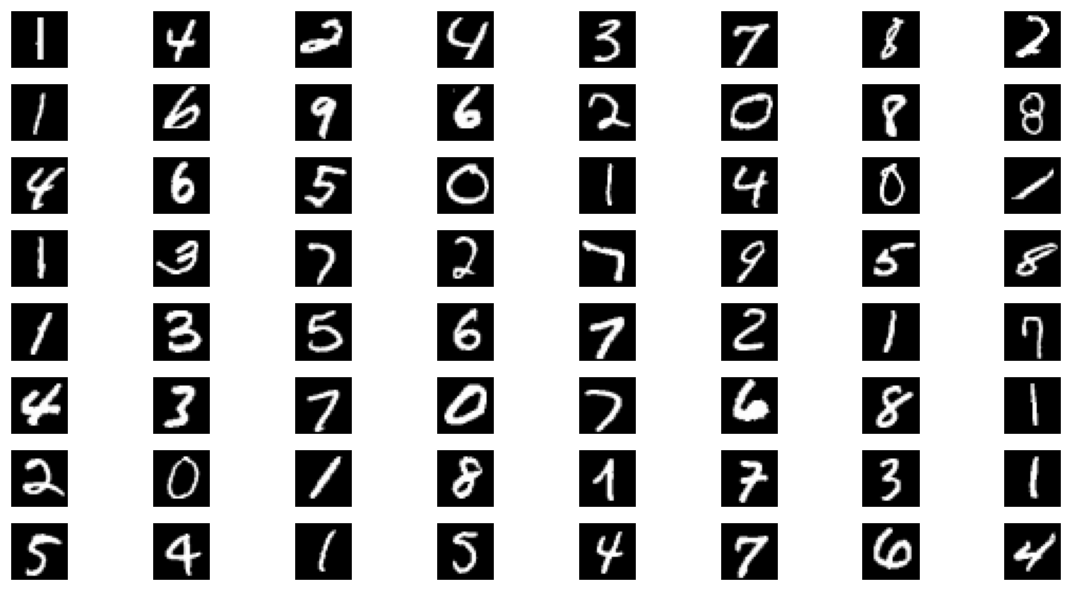

In [4]:


def display_image_batch(image_batch, n_cols=4, figsize=(12, 6)):
    
    plt.style.use('ggplot')
    n_images = len(image_batch)
    n_rows = math.ceil(n_images / n_cols)
    
    plt.figure(figsize=figsize)
    
    for idx in range(n_images):
        ax = plt.subplot(n_rows, n_cols, idx + 1)
        image = image_batch[idx]
        # Change dimensions from (C, H, W) to (H, W, C)
        image = image.permute(1, 2, 0)
        cmap = 'gray' if image.shape[2] == 1 else plt.cm.viridis
        ax.imshow(image, cmap=cmap)
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.show()

# Visualize the sample batch
display_image_batch(sample_batch[0], n_cols=8)


# Discriminator Network & Generator Network

In [5]:


# Discriminator class
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        # Discriminator will down-sample the input producing a binary output
        self.fc1 = nn.Linear(784, 128)
        self.leaky_relu1 = nn.LeakyReLU(negative_slope=0.2)
        self.fc2 = nn.Linear(128, 64)
        self.leaky_relu2 = nn.LeakyReLU(negative_slope=0.2)
        self.fc3 = nn.Linear(64, 32)
        self.leaky_relu3 = nn.LeakyReLU(negative_slope=0.2)
        self.fc4 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # Reshape passed image batch
        x = x.view(x.size(0), -1)
        # Feed forward
        x = self.fc1(x)
        x = self.leaky_relu1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.leaky_relu2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.leaky_relu3(x)
        x = self.dropout(x)
        logit_out = self.fc4(x)

        return logit_out

# Modified Generator class
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # Generator will up-sample the input producing input of size
        
        self.fc1 = nn.Linear(100, 32)
        self.leaky_relu1 = nn.LeakyReLU(negative_slope=0.2)
        self.fc2 = nn.Linear(32, 64)
        self.leaky_relu2 = nn.LeakyReLU(negative_slope=0.2)
        self.fc3 = nn.Linear(64, 128)
        self.leaky_relu3 = nn.LeakyReLU(negative_slope=0.2)
        self.fc4 = nn.Linear(128, 784)
        self.dropout = nn.Dropout(0.3)
        self.tanh = nn.Tanh()

    def forward(self, x):
        # Feed forward
        x = self.fc1(x)
        x = self.leaky_relu1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.leaky_relu2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.leaky_relu3(x)
        x = self.dropout(x)
        x = self.fc4(x)
        tanh_out = self.tanh(x)

        return tanh_out


# Define Losses

In [6]:


def real_loss(predicted_outputs, loss_fn, device):
    
    batch_size = predicted_outputs.shape[0]
    # Targets are set to 1 here because we expect prediction to be 
    
    targets = torch.ones(batch_size, device=device)
    real_loss = loss_fn(predicted_outputs.squeeze(), targets)
    
    return real_loss

def fake_loss(predicted_outputs, loss_fn, device):
    
    batch_size = predicted_outputs.shape[0]
    # Targets are set to 0 here because we expect prediction to be 
    
    targets = torch.zeros(batch_size, device=device)
    fake_loss = loss_fn(predicted_outputs.squeeze(), targets)
    
    return fake_loss


# Train the network

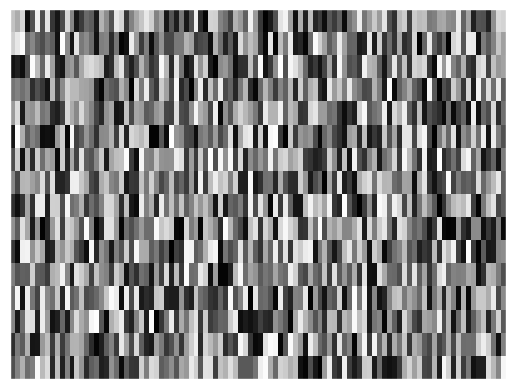

In [7]:
#Sample generation of latent vector

z_size = 100
z = np.random.uniform(-1, 1, size=(16, z_size))


plt.imshow(z, cmap='gray', aspect='auto')
plt.xticks([])
plt.yticks([])
plt.show()

In [8]:


def train_mnist_gan(d, g, d_optim, g_optim, loss_fn, dl, n_epochs, device, verbose=False):
    print(f'Training on [{device}]...')
    
    
    z_size = 100
    fixed_z = np.random.uniform(-1, 1, size=(16, z_size))
    fixed_z = torch.from_numpy(fixed_z).float().to(device)
    fixed_samples = []
    d_losses = []
    g_losses = []
    
    # Move discriminator and generator to available device
    d = d.to(device)
    g = g.to(device)
    
    for epoch in range(n_epochs):
        print(f'Epoch [{epoch+1}/{n_epochs}]:')
        # Switch the training mode on
        d.train()
        g.train()
        d_running_batch_loss = 0
        g_running_batch_loss = 0
        
        for curr_batch, (real_images, _) in enumerate(dl):
            
            real_images = real_images.to(device)
            
            
            
            # Reset gradients
            d_optim.zero_grad()
            
            
            
            real_images = (real_images * 2) - 1
            d_real_logits_out = d(real_images)
            d_real_loss = real_loss(d_real_logits_out, loss_fn, device)
            
            # Fake images
            with torch.no_grad():
                # Generate a batch of random latent vectors 
                z = np.random.uniform(-1, 1, size=(dl.batch_size, z_size))
                z = torch.from_numpy(z).float().to(device)
                # Generate a batch of fake images
                fake_images = g(z)
            
            # Feed fake-images to discriminator and compute the 
            
            d_fake_logits_out = d(fake_images)
            d_fake_loss = fake_loss(d_fake_logits_out, loss_fn, device)
            
            # Compute total discriminator loss
            d_loss = d_real_loss + d_fake_loss
            
            # Backpropagate through discriminator
            d_loss.backward()
            d_optim.step()
            
            # Save discriminator batch loss
            d_running_batch_loss += d_loss
            
            
            # Reset gradients
            g_optim.zero_grad()
            
            # Generate a batch of random latent vectors
            z = np.random.uniform(-1, 1, size=(dl.batch_size, z_size))
            z = torch.from_numpy(z).float().to(device)
            
            
            fake_images = g(z)
            g_logits_out = d(fake_images)
            g_loss = real_loss(g_logits_out, loss_fn, device)
            
            # Backpropagate through generator
            g_loss.backward()
            g_optim.step()
            
            # Save discriminator batch loss
            g_running_batch_loss += g_loss
            
            # Display training stats for every 200 batches 
            if curr_batch % 400 == 0 and verbose:
                print(f'\tBatch [{curr_batch:>4}/{len(dl):>4}] - d_batch_loss: {d_loss.item():.6f}\tg_batch_loss: {g_loss.item():.6f}')
            
        
        d_epoch_loss = d_running_batch_loss.item()/len(dl)
        g_epoch_loss = g_running_batch_loss.item()/len(dl)
        d_losses.append(d_epoch_loss)
        g_losses.append(g_epoch_loss)
        
        # Display training stats for every 200 batches 
        print(f'epoch_d_loss: {d_epoch_loss:.6f} \tepoch_g_loss: {g_epoch_loss:.6f}')
        
        # Generate fake images from fixed latent vector using the trained 
        
        g.eval()
        fixed_samples.append(g(fixed_z).detach().cpu())
        
    
    with open('fixed_samples.pkl', 'wb') as f:
        pkl.dump(fixed_samples, f)
     
    return d_losses, g_losses


In [9]:

# Instantiate Discriminator and Generator
d = Discriminator()
g = Generator()
print(d)
print()
print(g)

# Instantiate optimizers
d_optim = optim.Adam(d.parameters(), lr=0.002)
g_optim = optim.Adam(g.parameters(), lr=0.002)

# Instantiate the loss function
loss_fn = nn.BCEWithLogitsLoss()

# Setup device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Train
n_epochs = 100
d_losses, g_losses = train_mnist_gan(d, g, d_optim, g_optim,
                                     loss_fn, data_loader, n_epochs, device,
                                     verbose=False)


Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (leaky_relu1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (leaky_relu2): LeakyReLU(negative_slope=0.2)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (leaky_relu3): LeakyReLU(negative_slope=0.2)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Generator(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (leaky_relu1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (leaky_relu2): LeakyReLU(negative_slope=0.2)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (leaky_relu3): LeakyReLU(negative_slope=0.2)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (tanh): Tanh()
)
Training on [cpu]...
Epoch [1/100]:
epoch_d_loss: 1.189264 	epoch_g_loss: 1.622098
Epoch [2/100]:


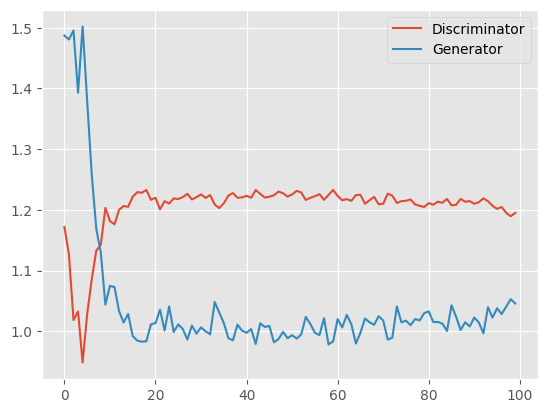

In [26]:
plt.plot(d_losses, label='Discriminator')
plt.plot(g_losses, label='Generator')
plt.legend()
plt.show()

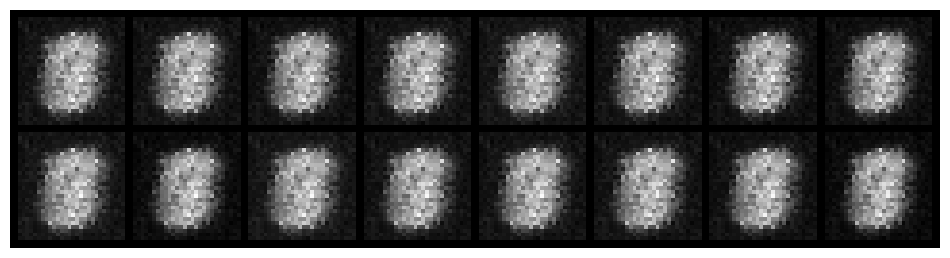

In [38]:
# Define the necessary functions and classes here

# Function to display generated images
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import pickle as pkl
import torch

def display_image_batch(images, n_cols, figsize):
    images_grid = vutils.make_grid(images, nrow=n_cols, normalize=True, padding=2)
    plt.figure(figsize=figsize)
    plt.imshow(images_grid.permute(1, 2, 0))  # Permute dimensions for proper display
    plt.axis('off')
    plt.show()

# Function to show generated images
def show_generated_images(epoch, n_cols=8):
    # Load saved images
    with open('fixed_samples.pkl', 'rb') as f:
        saved_data = pkl.load(f)  
    epoch_data = saved_data[epoch-1]
    # Re-scale back to 0-1 
    epoch_data = (epoch_data + 1) / 2
    # Re-shape to (batch_size, channel, height, width)
    batch_size, channel, height, width = len(epoch_data), 1, 28, 28
    image_batch = epoch_data.view(batch_size, channel, height, width)
    display_image_batch(images=image_batch, n_cols=n_cols, figsize=(12, 4))


# Show generated images for epoch 1 with 8 columns
show_generated_images(epoch=1, n_cols=8)



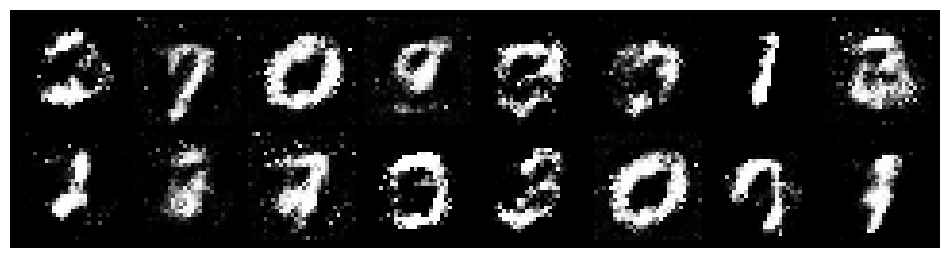

In [39]:
show_generated_images(epoch=10, n_cols=8)

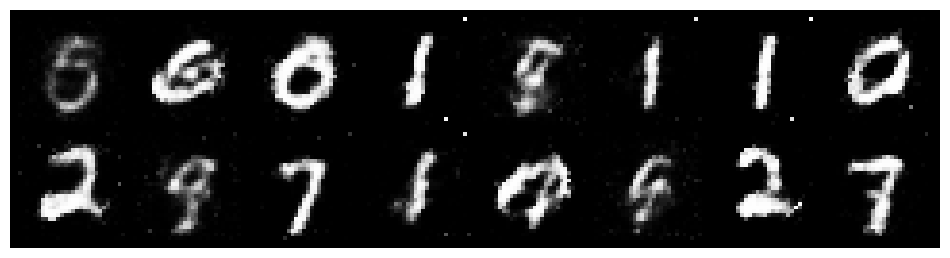

In [40]:
show_generated_images(epoch=100, n_cols=8)

# Test the network

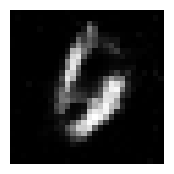

In [41]:
# Bring generator back to cpu and set eval mode on
g.to('cpu')
g.eval()
# Feed a latent vecor of size 100 to trained generator and get a fake generated image back
z = np.random.uniform(-1, 1, size=(1, 100))
z = torch.from_numpy(z).float()
fake_image = g(z)
# Reshape and display
fake_image = fake_image.view(1, 1, 28, 28).detach()
display_image_batch(fake_image, n_cols=1, figsize=(2, 2))

In [10]:
torch.save(g.state_dict(), 'generator_model.pth')
